# Small_Event_Classifier:

Adjusting class weights to deal with imbalanced dataset.

(Since oversampling is time-consuming, I just adjust class weights to deal with imbalanced dataset)

# Import packages and Datasets

In [0]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import keras
from keras import models
from keras import layers
from keras.layers import LSTM

import gc #Garbage Collector interface
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import sklearn.metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score #The F-Measure is a popular metric for imbalanced classification.
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

from sklearn.utils import class_weight

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
# import Google Drive 套件
from google.colab import drive

# 將自己的雲端硬碟掛載上去
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# 透過 gdrive/My Drive/... 來存取檔案
data_df = pd.read_excel('gdrive/My Drive/金融科技Final_project/2019+2020年新聞資訊事件_股價報酬_528.xlsx',sheet_name='year（小事件重分）')

In [0]:
data_df.head()

,個股代號,公司簡稱,事件日,TCRI(年/月),事件強度,收盤價,明日收盤價 / 昨日收盤價,明日收盤價 / 昨日收盤價 - 1,兩日報酬率(%),前5 ~ 245日平均兩日報酬率(%)，年平均正常報酬,前5 ~ 65日平均兩日報酬率(%)，季平均正常報酬,前5 ~ 25日平均兩日報酬率(%)，月平均正常報酬,前5 ~ 245日(年平均)兩日異常報酬,前5 ~ 65日(季平均)兩日異常報酬,前5 ~ 25日(月平均)兩日異常報酬,大事件類別,小事件類別,事件內容,Unnamed: 18,content_tokenized
0,1218,泰山,20190101,6(2018/09),0,19.00,0.972973,-0.027027,-2.702703,0.072009,-0.126391,0.911512,-2.774712,-2.576311,-3.614215,M_經營層,MT06_高管異動,發言人林俐婉內部調動，由江巍峰接任。。,19.0,發言人 林俐婉 內部 調動 由 江巍峰 接任
1,1503,士電,20190101,4(2018/09),0,40.95,0.997540,-0.002460,-0.246002,-0.000782,-0.459071,-0.042079,-0.245220,0.213068,-0.203923,M_經營層,MT06_高管異動,內部稽核主管林志強內部調動，由莊文清接任。。,22.0,內部 稽核 主管 林志強 內部 調動 由 莊文清 接任
2,1504,東元,20190101,4(2018/09),0,17.45,0.994302,-0.005698,-0.569801,-0.373847,-0.699126,0.436007,-0.195954,0.129325,-1.005807,M_經營層,MT06_高管異動,會計主管藍俊雄內部調動，由林鴻名接任。。,20.0,會計 主管 藍俊雄 內部 調動 由 林鴻名 接任
3,1709,和益,20190101,5(2018/09),0,14.80,1.003367,0.003367,0.336700,-0.097105,-0.364538,-0.160870,0.433805,0.701238,0.497570,M_經營層,MT06_高管異動,內部稽核主管游本詮內部調動，由曾筱茜接任。。,22.0,內部 稽核 主管 游本詮 內部 調動 由 曾筱茜 接任
4,1721,三晃,20190101,7(2018/09),0,10.05,1.000000,0.000000,0.000000,-0.275157,-0.026065,0.557661,0.275157,0.026065,-0.557661,M_經營層,MT06_高管異動,財務經理洪廷宜內部調動，由王婷渝接任。。,20.0,財務 經理 洪廷宜 內部 調動 由 王婷渝 接任


## Define "preprocess_text" functions

In [0]:
def preprocess_text(corpus, MAX_NUM_WORDS = 10000, MAX_SEQUENCE_LENGTH = 1000):
  tokenizer = keras .preprocessing.text.Tokenizer(num_words=MAX_NUM_WORDS)
  tokenizer.fit_on_texts(corpus)
  output = tokenizer.texts_to_sequences(corpus)
  output = keras .preprocessing .sequence .pad_sequences(output, maxlen=MAX_SEQUENCE_LENGTH)
  return output

## Data preprocessing

In [0]:
x = preprocess_text(corpus = data_df.content_tokenized, MAX_NUM_WORDS = 10000, MAX_SEQUENCE_LENGTH = 1305)

y = data_df["小事件類別"]

In [0]:
y.value_counts()

IS01_營收變動或客戶/商品/通路策略    13050
FS02_股價暴跌或異常             5972
產業前景_其他                  4076
IP01_成本/產能變動或資本支出        3502
經營層_其他                   2910
MT02_董監異動                2168
MT06_高管異動                2066
會計/財報分析_其他                314
市場交易_其他                   204
AF05_財務警示                 184
危機_其他                     150
RB01_TCRI負向觀察             140
RB02_TCRI降等               134
FS03_其他市場交易議題             120
AI01_延遲公告                  58
Name: 小事件類別, dtype: int64

## Split data into training dataset and testing dataset

In [0]:
# Split data to training data and testing data 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_par_train, X_val, y_par_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Calculate class weights

print(np.unique(y_train))

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

print(class_weights)

# One-hot encoding
enc = OneHotEncoder(sparse=False)
y_train = enc.fit(np.asarray(y).reshape(-1, 1))
y_par_train = enc.transform(np.asarray(y_par_train).reshape(-1, 1))
y_val = enc.transform(np.asarray(y_val).reshape(-1, 1))
y_test = enc.transform(np.asarray(y_test).reshape(-1, 1))

'''
# Oversampling
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_par_train_res, y_par_train_res = ros.fit_resample(X_par_train, y_par_train)
'''

['AF05_財務警示' 'AI01_延遲公告' 'FS02_股價暴跌或異常' 'FS03_其他市場交易議題'
 'IP01_成本/產能變動或資本支出' 'IS01_營收變動或客戶/商品/通路策略' 'MT02_董監異動' 'MT06_高管異動'
 'RB01_TCRI負向觀察' 'RB02_TCRI降等' '危機_其他' '市場交易_其他' '會計/財報分析_其他' '產業前景_其他'
 '經營層_其他']
[12.21699346 37.384       0.39318469 19.47083333  0.66614398  0.17900785
  1.07425287  1.14674847 17.30740741 17.97307692 15.19674797 10.99529412
  7.27315175  0.57127139  0.80120017]


'\n# Oversampling\nfrom imblearn.over_sampling import RandomOverSampler\nros = RandomOverSampler(random_state=0)\nX_par_train_res, y_par_train_res = ros.fit_resample(X_par_train, y_par_train)\n'

In [0]:
# save this encoder

from joblib import dump, load
dump(enc, 'gdrive/My Drive/金融科技Final_project/SE_enc.joblib') 

['gdrive/My Drive/金融科技Final_project/SE_enc.joblib']

# Model 0:

Adjust class weights

Without using oversampling

sequence length = 1305 (max length of our text data)

In [0]:
class_weights = [12.21699346, 37.384, 0.39318469, 19.47083333, 0.66614398, 0.17900785, 1.07425287, 1.14674847, 17.30740741, 17.97307692, 15.19674797, 10.99529412,
  7.27315175, 0.57127139, 0.80120017]

In [0]:
model_0 = models.Sequential()
model_0.add(layers.Embedding(10000, 128)) #256
# model_1.add(layers.LSTM(128,dropout=0.2,recurrent_dropout=0.2,return_sequences=True))
model_0.add(layers.LSTM(64,dropout=0,recurrent_dropout=0)) #128
model_0.add(layers.Dense(15, activation='softmax'))

model_0.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Iterate on your training data by calling the fit() method of your model
history = model_0.fit(X_par_train, y_par_train,
                    epochs=10,
                    batch_size=500,
                    validation_data = (X_val,y_val),
                    class_weight = class_weights
                    )

# plot the results of loss values from the training set and validtion set
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# plot the results of accuracy from the training set and validtion set
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Performance on partial training set

In [0]:
label = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]

preds_Y_par_train = model_0.predict(X_par_train)
preds_Y_par_train =(preds_Y_par_train>0.5).astype(int)

# decode categorical dummy variables to categorical variables
preds_Y_par_train_copy = enc.inverse_transform(preds_Y_par_train)
y_par_train_copy = enc.inverse_transform(y_par_train)

# Change all categorical data to numbers, so we can compute accuracy, precision, confusion matrix,....
le = sklearn.preprocessing.LabelEncoder()
y_par_train_copy = le.fit_transform(y_par_train_copy)
preds_Y_par_train_copy = le.transform(preds_Y_par_train_copy)

accuracy = accuracy_score(y_par_train_copy, preds_Y_par_train_copy)
precision = precision_score(y_par_train_copy, preds_Y_par_train_copy,average=None,labels=label) # average=None: The precision scores for each class are returned
recall = recall_score(y_par_train_copy, preds_Y_par_train_copy,average=None,labels=label)
f1 = f1_score(y_par_train_copy, preds_Y_par_train_copy,average=None,labels=label)
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')

c_matrix = confusion_matrix(y_par_train_copy, preds_Y_par＿train_copy,labels=label)
print('Confusion matrix: ')
print(c_matrix)

In [0]:
for i in label:
  print(le.inverse_transform([i]))

## Performance on testing set

In [0]:
label = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]

preds_Y_test = model_0.predict(X_test)
preds_Y_test =(preds_Y_test>0.5).astype(int)

# decode categorical dummy variables to categorical variables
preds_Y_test_copy = enc.inverse_transform(preds_Y_test)
y_test_copy = enc.inverse_transform(y_test)

# Change all categorical data to numbers, so we can compute accuracy, precision, confusion matrix,....
le = sklearn.preprocessing.LabelEncoder()
y_test_copy = le.fit_transform(y_test_copy)
preds_Y_test_copy = le.transform(preds_Y_test_copy)

accuracy = accuracy_score(y_test_copy, preds_Y_test_copy)
precision = precision_score(y_test_copy, preds_Y_test_copy,average=None,labels=label) # average=None: The precision scores for each class are returned
recall = recall_score(y_test_copy, preds_Y_test_copy,average=None,labels=label)
f1 = f1_score(y_test_copy, preds_Y_test_copy,average=None,labels=label)
c_matrix = confusion_matrix(y_test_copy, preds_Y_test_copy,labels=label)
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')
print('Confusion matrix: ')
print(c_matrix)

In [0]:
for i in label:
  print(le.inverse_transform([i]))

# Model 1: 

Adjust class weights

Without using oversampling

sequence length = 1305 (max length of our text data)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 22430 samples, validate on 5608 samples
Epoch 1/10
22430/22430 [==============================] - 163s 7ms/step - loss: 2.0320 - accuracy: 0.4949 - val_loss: 1.2035 - val_accuracy: 0.6113
Epoch 2/10
22430/22430 [==============================] - 161s 7ms/step - loss: 0.8265 - accuracy: 0.7724 - val_loss: 0.5998 - val_accuracy: 0.8308
Epoch 3/10
22430/22430 [==============================] - 163s 7ms/step - loss: 0.4807 - accuracy: 0.8712 - val_loss: 0.4444 - val_accuracy: 0.8782
Epoch 4/10
22430/22430 [==============================] - 159s 7ms/step - loss: 0.3458 - accuracy: 0.9131 - val_loss: 0.3729 - val_accuracy: 0.8980
Epoch 5/10
22430/22430 [==============================] - 159s 7ms/step - loss: 0.2702 - accuracy: 0.9321 - val_loss: 0.3462 - val_accuracy: 0.9037
Epoch 6/10
22430/22430 [==============================] - 161s 7ms/step - loss: 0.2434 - accuracy: 0.9370 - val_loss: 0.3408 - val_accuracy: 0.9067
Epoch 7/10
22430/22430 [==============================] - 159s 

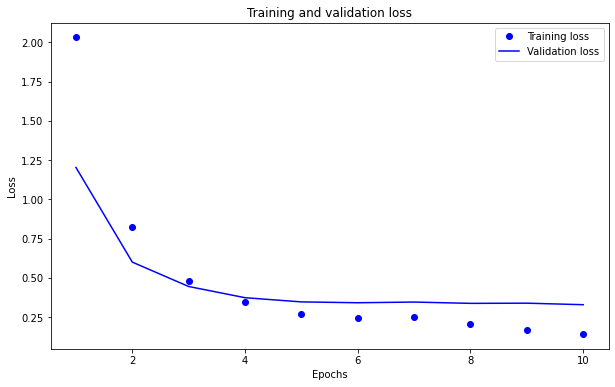

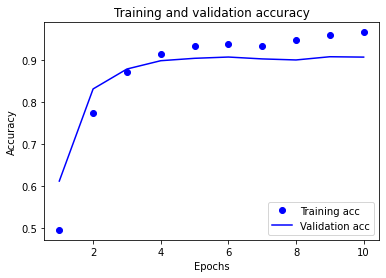

In [0]:
model_1 = models.Sequential()
model_1.add(layers.Embedding(10000, 128)) #256
# model_1.add(layers.LSTM(128,dropout=0.2,recurrent_dropout=0.2,return_sequences=True))
model_1.add(layers.LSTM(32,dropout=0,recurrent_dropout=0)) #128
model_1.add(layers.Dense(15, activation='softmax'))

model_1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Iterate on your training data by calling the fit() method of your model
history = model_1.fit(X_par_train, y_par_train,
                    epochs=10,
                    batch_size=500,
                    validation_data = (X_val,y_val),
                    class_weight = class_weights
                    )

# plot the results of loss values from the training set and validtion set
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# plot the results of accuracy from the training set and validtion set
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Performance on partial training set

In [0]:
label = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]

preds_Y_par_train = model_1.predict(X_par_train)
preds_Y_par_train =(preds_Y_par_train>0.5).astype(int)

# decode categorical dummy variables to categorical variables
preds_Y_par_train_copy = enc.inverse_transform(preds_Y_par_train)
y_par_train_copy = enc.inverse_transform(y_par_train)

# Change all categorical data to numbers, so we can compute accuracy, precision, confusion matrix,....
le = sklearn.preprocessing.LabelEncoder()
y_par_train_copy = le.fit_transform(y_par_train_copy)
preds_Y_par_train_copy = le.transform(preds_Y_par_train_copy)

accuracy = accuracy_score(y_par_train_copy, preds_Y_par_train_copy)
precision = precision_score(y_par_train_copy, preds_Y_par_train_copy,average=None,labels=label) # average=None: The precision scores for each class are returned
recall = recall_score(y_par_train_copy, preds_Y_par_train_copy,average=None,labels=label)
f1 = f1_score(y_par_train_copy, preds_Y_par_train_copy,average=None,labels=label)
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')

c_matrix = confusion_matrix(y_par_train_copy, preds_Y_par＿train_copy,labels=label)
print('Confusion matrix: ')
print(c_matrix)

accuracy: 0.9578689255461436

precision: [0.11096774 0.         1.         0.         0.96028559 0.99662081
 1.         1.         1.         0.95454545 0.         0.
 1.         0.95774648 0.98553055]

recall: [0.7107438  0.         0.99947876 0.         0.97024346 0.99088073
 0.99426112 0.99379845 0.71590909 0.26582278 0.         0.
 0.22926829 0.95774648 0.97507953]

F1 score: [0.19196429 0.         0.99973931 0.         0.96523884 0.99374248
 0.9971223  0.99688958 0.83443709 0.41584158 0.         0.
 0.37301587 0.95774648 0.98027719]

Confusion matrix: 
[[  86    0    0    0   25    2    0    0    0    0    0    0    0    8
     0]
 [  41    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [   1    0 3835    0    0    0    0    0    0    0    0    0    0    1
     0]
 [  71    0    0    0    3    0    0    0    0    0    0    0    0    2
     2]
 [  27    0    0    0 2152   12    0    0    0    0    0    0    0   26
     1]
 [  17    0    0    0   15 8258    0

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
for i in label:
  print(le.inverse_transform([i]))

['AF05_財務警示']
['AI01_延遲公告']
['FS02_股價暴跌或異常']
['FS03_其他市場交易議題']
['IP01_成本/產能變動或資本支出']
['IS01_營收變動或客戶/商品/通路策略']
['MT02_董監異動']
['MT06_高管異動']
['RB01_TCRI負向觀察']
['RB02_TCRI降等']
['危機_其他']
['市場交易_其他']
['會計/財報分析_其他']
['產業前景_其他']
['經營層_其他']


## Performance on testing set

In [0]:
label = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]

preds_Y_test = model_1.predict(X_test)
preds_Y_test =(preds_Y_test>0.5).astype(int)

# decode categorical dummy variables to categorical variables
preds_Y_test_copy = enc.inverse_transform(preds_Y_test)
y_test_copy = enc.inverse_transform(y_test)

# Change all categorical data to numbers, so we can compute accuracy, precision, confusion matrix,....
le = sklearn.preprocessing.LabelEncoder()
y_test_copy = le.fit_transform(y_test_copy)
preds_Y_test_copy = le.transform(preds_Y_test_copy)

accuracy = accuracy_score(y_test_copy, preds_Y_test_copy)
precision = precision_score(y_test_copy, preds_Y_test_copy,average=None,labels=label) # average=None: The precision scores for each class are returned
recall = recall_score(y_test_copy, preds_Y_test_copy,average=None,labels=label)
f1 = f1_score(y_test_copy, preds_Y_test_copy,average=None,labels=label)
c_matrix = confusion_matrix(y_test_copy, preds_Y_test_copy,labels=label)
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')
print('Confusion matrix: ')
print(c_matrix)

accuracy: 0.8988587731811698

precision: [0.06315789 0.         0.99917898 0.         0.82326951 0.96584217
 1.         1.         1.         1.         0.         0.
 1.         0.77224199 0.92207792]

recall: [0.58064516 0.         0.99917898 0.         0.80316092 0.94325153
 0.9953271  0.99311927 0.6875     0.33333333 0.         0.
 0.14035088 0.80970149 0.86135182]

F1 score: [0.11392405 0.         0.99917898 0.         0.81309091 0.95441319
 0.99765808 0.99654776 0.81481481 0.5        0.         0.
 0.24615385 0.79052823 0.890681  ]

Confusion matrix: 
[[  18    0    0    0    7    4    0    0    0    0    0    0    0    2
     0]
 [   7    0    0    0    0    0    0    0    0    0    0    0    0    1
     0]
 [   0    0 1217    0    0    1    0    0    0    0    0    0    0    0
     0]
 [  18    0    0    0    1    0    0    0    0    0    0    0    0    4
     1]
 [  26    0    0    0  559   46    0    0    0    0    0    0    0   64
     1]
 [  36    0    1    0   53 2460    0

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
for i in label:
  print(le.inverse_transform([i]))

['AF05_財務警示']
['AI01_延遲公告']
['FS02_股價暴跌或異常']
['FS03_其他市場交易議題']
['IP01_成本/產能變動或資本支出']
['IS01_營收變動或客戶/商品/通路策略']
['MT02_董監異動']
['MT06_高管異動']
['RB01_TCRI負向觀察']
['RB02_TCRI降等']
['危機_其他']
['市場交易_其他']
['會計/財報分析_其他']
['產業前景_其他']
['經營層_其他']


# Model 2: 

Adjust class weights

Epochs = 10

sequence length = 1305 (max length of our text data)

In [0]:
class_weights = [12.21699346, 37.384*2, 0.39318469, 19.47083333*2, 0.66614398, 0.17900785, 1.07425287, 1.14674847, 17.30740741*2, 17.97307692*2, 15.19674797*2, 10.99529412, 7.27315175, 0.57127139, 0.80120017]

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 22430 samples, validate on 5608 samples
Epoch 1/10
22430/22430 [==============================] - 159s 7ms/step - loss: 2.0227 - accuracy: 0.5216 - val_loss: 1.2308 - val_accuracy: 0.6648
Epoch 2/10
22430/22430 [==============================] - 158s 7ms/step - loss: 0.8639 - accuracy: 0.7761 - val_loss: 0.6359 - val_accuracy: 0.8263
Epoch 3/10
22430/22430 [==============================] - 159s 7ms/step - loss: 0.5028 - accuracy: 0.8768 - val_loss: 0.4503 - val_accuracy: 0.8805
Epoch 4/10
22430/22430 [==============================] - 158s 7ms/step - loss: 0.3601 - accuracy: 0.9100 - val_loss: 0.3875 - val_accuracy: 0.8873
Epoch 5/10
22430/22430 [==============================] - 158s 7ms/step - loss: 0.2856 - accuracy: 0.9292 - val_loss: 0.3682 - val_accuracy: 0.8939
Epoch 6/10
22430/22430 [==============================] - 158s 7ms/step - loss: 0.2368 - accuracy: 0.9424 - val_loss: 0.3602 - val_accuracy: 0.8957
Epoch 7/10
22430/22430 [==============================] - 157s 

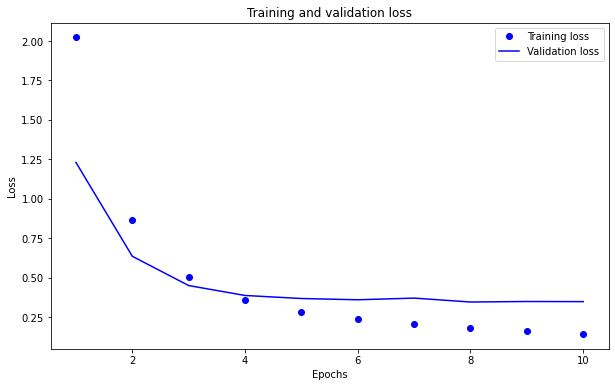

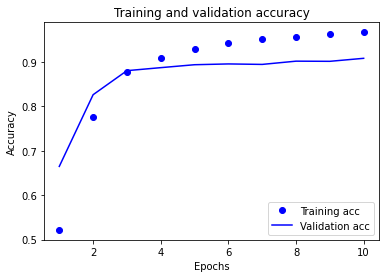

In [0]:
model_2 = models.Sequential()
model_2.add(layers.Embedding(10000, 128)) #256
# model_1.add(layers.LSTM(128,dropout=0.2,recurrent_dropout=0.2,return_sequences=True))
model_2.add(layers.LSTM(32,dropout=0,recurrent_dropout=0)) #128
model_2.add(layers.Dense(15, activation='softmax'))

model_2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Iterate on your training data by calling the fit() method of your model
history = model_2.fit(X_par_train, y_par_train,
                    epochs=10,
                    batch_size=500,
                    validation_data = (X_val,y_val),
                    class_weight = class_weights
                    )

# plot the results of loss values from the training set and validtion set
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# plot the results of accuracy from the training set and validtion set
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Performance on partial training set

In [0]:
label = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]

preds_Y_par_train = model_2.predict(X_par_train)
preds_Y_par_train =(preds_Y_par_train>0.5).astype(int)

# decode categorical dummy variables to categorical variables
preds_Y_par_train_copy = enc.inverse_transform(preds_Y_par_train)
y_par_train_copy = enc.inverse_transform(y_par_train)

# Change all categorical data to numbers, so we can compute accuracy, precision, confusion matrix,....
le = sklearn.preprocessing.LabelEncoder()
y_par_train_copy = le.fit_transform(y_par_train_copy)
preds_Y_par_train_copy = le.transform(preds_Y_par_train_copy)

accuracy = accuracy_score(y_par_train_copy, preds_Y_par_train_copy)
precision = precision_score(y_par_train_copy, preds_Y_par_train_copy,average=None,labels=label) # average=None: The precision scores for each class are returned
recall = recall_score(y_par_train_copy, preds_Y_par_train_copy,average=None,labels=label)
f1 = f1_score(y_par_train_copy, preds_Y_par_train_copy,average=None,labels=label)
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')

c_matrix = confusion_matrix(y_par_train_copy, preds_Y_par＿train_copy,labels=label)
print('Confusion matrix: ')
print(c_matrix)

accuracy: 0.9555506018724922

precision: [0.09987358 0.         1.         0.         0.95942934 0.99208918
 1.         1.         0.         0.         0.         0.
 1.         0.9627782  0.98365841]

recall: [0.65289256 0.         0.99947876 0.         0.97024346 0.99316055
 0.99354376 0.99302326 0.         0.         0.         0.
 0.23902439 0.95508184 0.98939555]

F1 score: [0.17324561 0.         0.99973931 0.         0.9648061  0.99262457
 0.99676142 0.99649942 0.         0.         0.         0.
 0.38582677 0.95891458 0.98651864]

Confusion matrix: 
[[  79    0    0    0   31    3    0    0    0    0    0    0    0    8
     0]
 [  41    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [   1    0 3835    0    0    0    0    0    0    0    0    0    0    1
     0]
 [  69    0    0    0    0    0    0    0    0    0    0    0    0    2
     7]
 [   9    0    0    0 2152   26    0    0    0    0    0    0    0   31
     0]
 [  11    0    0    0   18 8277    0

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
for i in label:
  print(le.inverse_transform([i]))

['AF05_財務警示']
['AI01_延遲公告']
['FS02_股價暴跌或異常']
['FS03_其他市場交易議題']
['IP01_成本/產能變動或資本支出']
['IS01_營收變動或客戶/商品/通路策略']
['MT02_董監異動']
['MT06_高管異動']
['RB01_TCRI負向觀察']
['RB02_TCRI降等']
['危機_其他']
['市場交易_其他']
['會計/財報分析_其他']
['產業前景_其他']
['經營層_其他']


## Performance on testing set

In [0]:
label = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]

preds_Y_test = model_2.predict(X_test)
preds_Y_test =(preds_Y_test>0.5).astype(int)

# decode categorical dummy variables to categorical variables
preds_Y_test_copy = enc.inverse_transform(preds_Y_test)
y_test_copy = enc.inverse_transform(y_test)

# Change all categorical data to numbers, so we can compute accuracy, precision, confusion matrix,....
le = sklearn.preprocessing.LabelEncoder()
y_test_copy = le.fit_transform(y_test_copy)
preds_Y_test_copy = le.transform(preds_Y_test_copy)

accuracy = accuracy_score(y_test_copy, preds_Y_test_copy)
precision = precision_score(y_test_copy, preds_Y_test_copy,average=None,labels=label) # average=None: The precision scores for each class are returned
recall = recall_score(y_test_copy, preds_Y_test_copy,average=None,labels=label)
f1 = f1_score(y_test_copy, preds_Y_test_copy,average=None,labels=label)
c_matrix = confusion_matrix(y_test_copy, preds_Y_test_copy,labels=label)
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')
print('Confusion matrix: ')
print(c_matrix)

accuracy: 0.8978601997146933

precision: [0.06882591 0.         1.         0.         0.80291971 0.94728859
 1.         1.         0.         0.         0.         0.
 1.         0.78388278 0.93506494]

recall: [0.5483871  0.         0.99917898 0.         0.79022989 0.95782209
 0.9953271  0.99082569 0.         0.         0.         0.
 0.14035088 0.79850746 0.87348354]

F1 score: [0.12230216 0.         0.99958932 0.         0.79652426 0.95252622
 0.99765808 0.99539171 0.         0.         0.         0.
 0.24615385 0.79112754 0.90322581]

Confusion matrix: 
[[  17    0    0    0    6    5    0    0    0    0    0    0    0    3
     0]
 [   7    0    0    0    0    0    0    0    0    0    0    0    0    1
     0]
 [   0    0 1217    0    0    1    0    0    0    0    0    0    0    0
     0]
 [  14    0    0    0    2    1    0    0    0    0    0    0    0    5
     2]
 [  11    0    0    0  550   70    0    0    0    0    0    0    0   65
     0]
 [  11    0    0    0   68 2498    0

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
for i in label:
  print(le.inverse_transform([i]))

['AF05_財務警示']
['AI01_延遲公告']
['FS02_股價暴跌或異常']
['FS03_其他市場交易議題']
['IP01_成本/產能變動或資本支出']
['IS01_營收變動或客戶/商品/通路策略']
['MT02_董監異動']
['MT06_高管異動']
['RB01_TCRI負向觀察']
['RB02_TCRI降等']
['危機_其他']
['市場交易_其他']
['會計/財報分析_其他']
['產業前景_其他']
['經營層_其他']


# Model 3:

sequence length = 1305 (max length of our text data)

3 hidden dense layers.

In [0]:
class_weights = [12.21699346, 37.384, 0.39318469, 19.47083333, 0.66614398, 0.17900785, 1.07425287, 1.14674847, 17.30740741, 17.97307692, 15.19674797, 10.99529412,
  7.27315175, 0.57127139, 0.80120017]

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 22430 samples, validate on 5608 samples
Epoch 1/10
22430/22430 [==============================] - 103s 5ms/step - loss: 1.9429 - accuracy: 0.4842 - val_loss: 1.0242 - val_accuracy: 0.6311
Epoch 2/10
22430/22430 [==============================] - 102s 5ms/step - loss: 0.6420 - accuracy: 0.8120 - val_loss: 0.4671 - val_accuracy: 0.8468
Epoch 3/10
22430/22430 [==============================] - 100s 4ms/step - loss: 0.3461 - accuracy: 0.8909 - val_loss: 0.3651 - val_accuracy: 0.8843
Epoch 4/10
22430/22430 [==============================] - 100s 4ms/step - loss: 0.2575 - accuracy: 0.9218 - val_loss: 0.3403 - val_accuracy: 0.8937
Epoch 5/10
22430/22430 [==============================] - 100s 4ms/step - loss: 0.2137 - accuracy: 0.9346 - val_loss: 0.3377 - val_accuracy: 0.8887
Epoch 6/10
22430/22430 [==============================] - 102s 5ms/step - loss: 0.1745 - accuracy: 0.9463 - val_loss: 0.3315 - val_accuracy: 0.8976
Epoch 7/10
22430/22430 [==============================] - 103s 

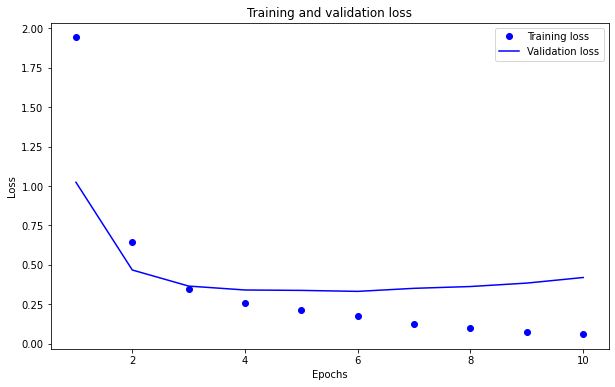

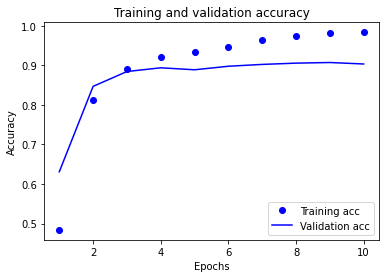

In [0]:
model_3 = models.Sequential()
model_3.add(layers.Embedding(10000, 128))
# model_1.add(layers.LSTM(128,dropout=0.2,recurrent_dropout=0.2,return_sequences=True))
model_3.add(layers.LSTM(64,dropout=0,recurrent_dropout=0))
model_3.add(layers.Dense(32, activation='relu'))
model_3.add(layers.Dense(32, activation='relu'))
model_3.add(layers.Dense(15, activation='softmax'))

model_3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Iterate on your training data by calling the fit() method of your model
history = model_3.fit(X_par_train, y_par_train,
                    epochs=10,
                    batch_size=500,
                    validation_data = (X_val,y_val),
                    class_weight = class_weights
                    )

# plot the results of loss values from the training set and validtion set
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# plot the results of accuracy from the training set and validtion set
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Performance on partial training set

In [0]:
label = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]

preds_Y_par_train = model_3.predict(X_par_train)
preds_Y_par_train =(preds_Y_par_train>0.5).astype(int)

# decode categorical dummy variables to categorical variables
preds_Y_par_train_copy = enc.inverse_transform(preds_Y_par_train)
y_par_train_copy = enc.inverse_transform(y_par_train)

# Change all categorical data to numbers, so we can compute accuracy, precision, confusion matrix,....
le = sklearn.preprocessing.LabelEncoder()
y_par_train_copy = le.fit_transform(y_par_train_copy)
preds_Y_par_train_copy = le.transform(preds_Y_par_train_copy)

accuracy = accuracy_score(y_par_train_copy, preds_Y_par_train_copy)
precision = precision_score(y_par_train_copy, preds_Y_par_train_copy,average=None,labels=label) # average=None: The precision scores for each class are returned
recall = recall_score(y_par_train_copy, preds_Y_par_train_copy,average=None,labels=label)
f1 = f1_score(y_par_train_copy, preds_Y_par_train_copy,average=None,labels=label)
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')

c_matrix = confusion_matrix(y_par_train_copy, preds_Y_par＿train_copy,labels=label)
print('Confusion matrix: ')
print(c_matrix)

accuracy: 0.9845296477931342

precision: [0.32624113 1.         1.         0.975      0.98997265 0.99819733
 0.99856219 0.99922058 0.97183099 0.92753623 0.98684211 0.9
 0.95431472 0.97336834 0.9899789 ]

recall: [0.76033058 0.46341463 0.99947876 0.5        0.9792606  0.99664027
 0.9964132  0.99379845 0.78409091 0.81012658 0.75       0.61363636
 0.91707317 0.9878188  0.995228  ]

F1 score: [0.45657568 0.63333333 0.99973931 0.66101695 0.98458749 0.99741819
 0.99748654 0.99650214 0.86792453 0.86486486 0.85227273 0.72972973
 0.93532338 0.98054034 0.99259651]

Confusion matrix: 
[[  92    0    0    1   12    1    2    0    0    0    0    1    2    2
     8]
 [  19   19    0    0    0    0    0    0    0    0    0    0    3    0
     0]
 [   1    0 3835    0    0    0    0    0    0    0    0    0    0    0
     1]
 [  32    0    0   39    0    0    0    0    0    0    0    5    0    0
     2]
 [   9    0    0    0 2172    5    0    0    0    0    0    0    0   32
     0]
 [   4    0    0   

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
for i in label:
  print(le.inverse_transform([i]))

['AF05_財務警示']
['AI01_延遲公告']
['FS02_股價暴跌或異常']
['FS03_其他市場交易議題']
['IP01_成本/產能變動或資本支出']
['IS01_營收變動或客戶/商品/通路策略']
['MT02_董監異動']
['MT06_高管異動']
['RB01_TCRI負向觀察']
['RB02_TCRI降等']
['危機_其他']
['市場交易_其他']
['會計/財報分析_其他']
['產業前景_其他']
['經營層_其他']


## Performance on testing set

In [0]:
label = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]

preds_Y_test = model_3.predict(X_test)
preds_Y_test =(preds_Y_test>0.5).astype(int)

# decode categorical dummy variables to categorical variables
preds_Y_test_copy = enc.inverse_transform(preds_Y_test)
y_test_copy = enc.inverse_transform(y_test)

# Change all categorical data to numbers, so we can compute accuracy, precision, confusion matrix,....
le = sklearn.preprocessing.LabelEncoder()
y_test_copy = le.fit_transform(y_test_copy)
preds_Y_test_copy = le.transform(preds_Y_test_copy)

accuracy = accuracy_score(y_test_copy, preds_Y_test_copy)
precision = precision_score(y_test_copy, preds_Y_test_copy,average=None,labels=label) # average=None: The precision scores for each class are returned
recall = recall_score(y_test_copy, preds_Y_test_copy,average=None,labels=label)
f1 = f1_score(y_test_copy, preds_Y_test_copy,average=None,labels=label)
c_matrix = confusion_matrix(y_test_copy, preds_Y_test_copy,labels=label)
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')
print('Confusion matrix: ')
print(c_matrix)

accuracy: 0.9048502139800285

precision: [0.12173913 1.         1.         0.8        0.79738562 0.94304281
 1.         1.         0.80645161 0.88888889 0.94117647 0.8
 0.7        0.75928009 0.90777577]

recall: [0.4516129  0.375      0.99917898 0.33333333 0.70114943 0.94593558
 0.9953271  0.99541284 0.78125    0.8        0.59259259 0.47058824
 0.49122807 0.83955224 0.87001733]

F1 score: [0.19178082 0.54545455 0.99958932 0.47058824 0.74617737 0.94448698
 0.99765808 0.99770115 0.79365079 0.84210526 0.72727273 0.59259259
 0.57731959 0.79740106 0.88849558]

Confusion matrix: 
[[  14    0    0    0    2    7    0    0    0    0    0    1    0    4
     3]
 [   4    3    0    0    0    0    0    0    0    0    0    0    0    1
     0]
 [   0    0 1217    0    0    1    0    0    0    0    0    0    0    0
     0]
 [   6    0    0    8    1    0    0    0    0    0    1    0    0    4
     4]
 [  11    0    0    0  488   98    0    0    0    0    0    0    1   92
     6]
 [  12    0    0   

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
for i in label:
  print(le.inverse_transform([i]))

['AF05_財務警示']
['AI01_延遲公告']
['FS02_股價暴跌或異常']
['FS03_其他市場交易議題']
['IP01_成本/產能變動或資本支出']
['IS01_營收變動或客戶/商品/通路策略']
['MT02_董監異動']
['MT06_高管異動']
['RB01_TCRI負向觀察']
['RB02_TCRI降等']
['危機_其他']
['市場交易_其他']
['會計/財報分析_其他']
['產業前景_其他']
['經營層_其他']


# Model 4:

sequence length = 1305 (max length of our text data)

4 hidden dense layers.

In [0]:
class_weights = [12.21699346, 37.384, 0.39318469, 19.47083333, 0.66614398, 0.17900785, 1.07425287, 1.14674847, 17.30740741, 17.97307692, 15.19674797, 10.99529412,
  7.27315175, 0.57127139, 0.80120017]

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 22430 samples, validate on 5608 samples
Epoch 1/10
22430/22430 [==============================] - 101s 5ms/step - loss: 1.9779 - accuracy: 0.4655 - val_loss: 1.1943 - val_accuracy: 0.6578
Epoch 2/10
22430/22430 [==============================] - 102s 5ms/step - loss: 0.7734 - accuracy: 0.7679 - val_loss: 0.5918 - val_accuracy: 0.8377
Epoch 3/10
22430/22430 [==============================] - 100s 4ms/step - loss: 0.4127 - accuracy: 0.8791 - val_loss: 0.4140 - val_accuracy: 0.8632
Epoch 4/10
22430/22430 [==============================] - 103s 5ms/step - loss: 0.2860 - accuracy: 0.9100 - val_loss: 0.3860 - val_accuracy: 0.8754
Epoch 5/10
22430/22430 [==============================] - 102s 5ms/step - loss: 0.2267 - accuracy: 0.9268 - val_loss: 0.3886 - val_accuracy: 0.8761
Epoch 6/10
22430/22430 [==============================] - 98s 4ms/step - loss: 0.1791 - accuracy: 0.9414 - val_loss: 0.4038 - val_accuracy: 0.8848
Epoch 7/10
22430/22430 [==============================] - 101s 4

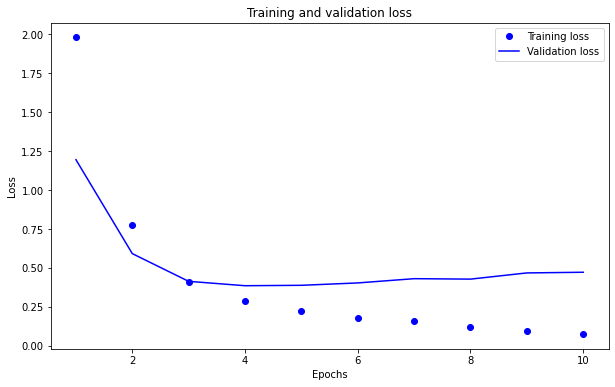

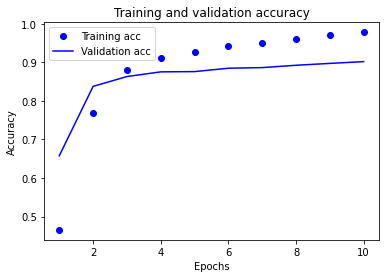

In [0]:
model_4 = models.Sequential()
model_4.add(layers.Embedding(10000, 128))
# model_1.add(layers.LSTM(128,dropout=0.2,recurrent_dropout=0.2,return_sequences=True))
model_4.add(layers.LSTM(64,dropout=0,recurrent_dropout=0))
model_4.add(layers.Dense(32, activation='relu'))
model_4.add(layers.Dense(32, activation='relu'))
model_4.add(layers.Dense(32, activation='relu'))
model_4.add(layers.Dense(15, activation='softmax'))

model_4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Iterate on your training data by calling the fit() method of your model
history = model_4.fit(X_par_train, y_par_train,
                    epochs=10,
                    batch_size=500,
                    validation_data = (X_val,y_val),
                    class_weight = class_weights
                    )

# plot the results of loss values from the training set and validtion set
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# plot the results of accuracy from the training set and validtion set
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Performance on partial training set

In [0]:
label = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]

preds_Y_par_train = model_4.predict(X_par_train)
preds_Y_par_train =(preds_Y_par_train>0.5).astype(int)

# decode categorical dummy variables to categorical variables
preds_Y_par_train_copy = enc.inverse_transform(preds_Y_par_train)
y_par_train_copy = enc.inverse_transform(y_par_train)

# Change all categorical data to numbers, so we can compute accuracy, precision, confusion matrix,....
le = sklearn.preprocessing.LabelEncoder()
y_par_train_copy = le.fit_transform(y_par_train_copy)
preds_Y_par_train_copy = le.transform(preds_Y_par_train_copy)

accuracy = accuracy_score(y_par_train_copy, preds_Y_par_train_copy)
precision = precision_score(y_par_train_copy, preds_Y_par_train_copy,average=None,labels=label) # average=None: The precision scores for each class are returned
recall = recall_score(y_par_train_copy, preds_Y_par_train_copy,average=None,labels=label)
f1 = f1_score(y_par_train_copy, preds_Y_par_train_copy,average=None,labels=label)
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')

c_matrix = confusion_matrix(y_par_train_copy, preds_Y_par＿train_copy,labels=label)
print('Confusion matrix: ')
print(c_matrix)

accuracy: 0.9723584485064646

precision: [0.19420784 0.         1.         0.         0.97183099 0.99891331
 0.99928212 1.         0.         0.         1.         0.
 0.92432432 0.98139711 0.99468933]

recall: [0.94214876 0.         0.99947876 0.         0.99549143 0.99268059
 0.99856528 0.99534884 0.         0.         0.75       0.
 0.83414634 0.98401218 0.9931071 ]

F1 score: [0.3220339  0.         0.99973931 0.         0.98351893 0.99578719
 0.99892357 0.997669   0.         0.         0.85714286 0.
 0.87692308 0.98270291 0.99389759]

Confusion matrix: 
[[ 114    0    0    0    1    1    0    0    0    0    0    0    0    3
     2]
 [  39    0    0    0    0    0    0    0    0    0    0    0    2    0
     0]
 [   1    0 3835    0    0    0    0    0    0    0    0    0    0    1
     0]
 [  66    0    0    0    1    0    0    0    0    0    0    0    3    7
     1]
 [   0    0    0    0 2208    6    0    0    0    0    0    0    0    4
     0]
 [   7    0    0    0   39 8273    0

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
for i in label:
  print(le.inverse_transform([i]))

['AF05_財務警示']
['AI01_延遲公告']
['FS02_股價暴跌或異常']
['FS03_其他市場交易議題']
['IP01_成本/產能變動或資本支出']
['IS01_營收變動或客戶/商品/通路策略']
['MT02_董監異動']
['MT06_高管異動']
['RB01_TCRI負向觀察']
['RB02_TCRI降等']
['危機_其他']
['市場交易_其他']
['會計/財報分析_其他']
['產業前景_其他']
['經營層_其他']


## Performance on testing set

In [0]:
label = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]

preds_Y_test = model_4.predict(X_test)
preds_Y_test =(preds_Y_test>0.5).astype(int)

# decode categorical dummy variables to categorical variables
preds_Y_test_copy = enc.inverse_transform(preds_Y_test)
y_test_copy = enc.inverse_transform(y_test)

# Change all categorical data to numbers, so we can compute accuracy, precision, confusion matrix,....
le = sklearn.preprocessing.LabelEncoder()
y_test_copy = le.fit_transform(y_test_copy)
preds_Y_test_copy = le.transform(preds_Y_test_copy)

accuracy = accuracy_score(y_test_copy, preds_Y_test_copy)
precision = precision_score(y_test_copy, preds_Y_test_copy,average=None,labels=label) # average=None: The precision scores for each class are returned
recall = recall_score(y_test_copy, preds_Y_test_copy,average=None,labels=label)
f1 = f1_score(y_test_copy, preds_Y_test_copy,average=None,labels=label)
c_matrix = confusion_matrix(y_test_copy, preds_Y_test_copy,labels=label)
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')
print('Confusion matrix: ')
print(c_matrix)

accuracy: 0.8961483594864479

precision: [0.06730769 0.         1.         0.         0.76648352 0.95243575
 0.9953271  1.         0.         0.         0.9375     0.
 0.81578947 0.76621787 0.9245648 ]

recall: [0.4516129  0.         0.99917898 0.         0.80172414 0.95207055
 0.9953271  0.99541284 0.         0.         0.55555556 0.
 0.54385965 0.77860697 0.82842288]

F1 score: [0.11715481 0.         0.99958932 0.         0.78370787 0.95225312
 0.9953271  0.99770115 0.         0.         0.69767442 0.
 0.65263158 0.77236274 0.8738574 ]

Confusion matrix: 
[[  14    0    0    0    5    7    0    0    0    0    0    0    1    4
     0]
 [   7    0    0    0    0    0    0    0    0    0    0    0    0    1
     0]
 [   0    0 1217    0    0    1    0    0    0    0    0    0    0    0
     0]
 [  12    0    0    0    1    1    0    0    0    0    0    0    1    8
     1]
 [   4    0    0    0  558   75    0    0    0    0    0    0    0   56
     3]
 [  16    0    0    0   77 2483    1

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
for i in label:
  print(le.inverse_transform([i]))

['AF05_財務警示']
['AI01_延遲公告']
['FS02_股價暴跌或異常']
['FS03_其他市場交易議題']
['IP01_成本/產能變動或資本支出']
['IS01_營收變動或客戶/商品/通路策略']
['MT02_董監異動']
['MT06_高管異動']
['RB01_TCRI負向觀察']
['RB02_TCRI降等']
['危機_其他']
['市場交易_其他']
['會計/財報分析_其他']
['產業前景_其他']
['經營層_其他']


# Model 5: Model 3 + Dropout

sequence length = 1305 (max length of our text data)

3 hidden dense layers.

Dropout: 0.1

In [0]:
class_weights = [12.21699346, 37.384, 0.39318469, 19.47083333, 0.66614398, 0.17900785, 1.07425287, 1.14674847, 17.30740741, 17.97307692, 15.19674797, 10.99529412,
  7.27315175, 0.57127139, 0.80120017]

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 22430 samples, validate on 5608 samples
Epoch 1/10
22430/22430 [==============================] - 116s 5ms/step - loss: 1.8419 - accuracy: 0.4428 - val_loss: 1.0525 - val_accuracy: 0.6088
Epoch 2/10
22430/22430 [==============================] - 117s 5ms/step - loss: 0.8725 - accuracy: 0.6649 - val_loss: 0.6290 - val_accuracy: 0.7400
Epoch 3/10
22430/22430 [==============================] - 116s 5ms/step - loss: 0.5439 - accuracy: 0.8046 - val_loss: 0.4255 - val_accuracy: 0.8741
Epoch 4/10
22430/22430 [==============================] - 117s 5ms/step - loss: 0.3648 - accuracy: 0.8847 - val_loss: 0.3703 - val_accuracy: 0.8811
Epoch 5/10
22430/22430 [==============================] - 117s 5ms/step - loss: 0.2817 - accuracy: 0.9106 - val_loss: 0.3705 - val_accuracy: 0.8796
Epoch 6/10
22430/22430 [==============================] - 119s 5ms/step - loss: 0.2315 - accuracy: 0.9266 - val_loss: 0.3841 - val_accuracy: 0.8823
Epoch 7/10
22430/22430 [==============================] - 117s 

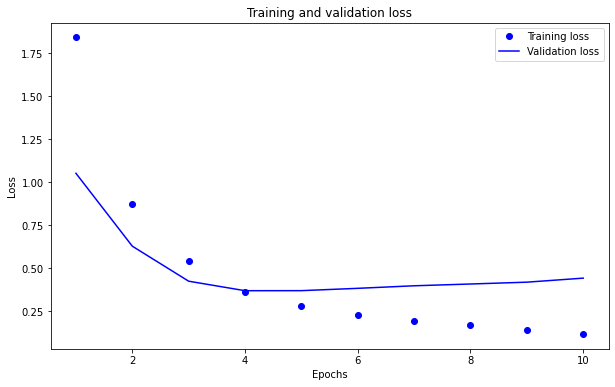

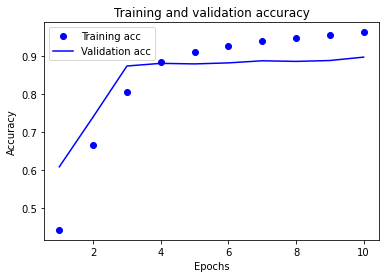

In [0]:
model_5 = models.Sequential()
model_5.add(layers.Embedding(10000, 128))
# model_5.add(layers.LSTM(128,dropout=0.2,recurrent_dropout=0.2,return_sequences=True))
model_5.add(layers.LSTM(64,dropout=0.1,recurrent_dropout=0.1))
model_5.add(layers.Dense(32, activation='relu'))
model_5.add(layers.Dropout(0.1))
model_5.add(layers.Dense(32, activation='relu'))
model_5.add(layers.Dropout(0.1))
model_5.add(layers.Dense(15, activation='softmax'))

model_5.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Iterate on your training data by calling the fit() method of your model
history = model_5.fit(X_par_train, y_par_train,
                    epochs=10,
                    batch_size=500,
                    validation_data = (X_val,y_val),
                    class_weight = class_weights
                    )

# plot the results of loss values from the training set and validtion set
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# plot the results of accuracy from the training set and validtion set
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Performance on partial training set

In [0]:
label = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]

preds_Y_par_train = model_5.predict(X_par_train)
preds_Y_par_train =(preds_Y_par_train>0.5).astype(int)

# decode categorical dummy variables to categorical variables
preds_Y_par_train_copy = enc.inverse_transform(preds_Y_par_train)
y_par_train_copy = enc.inverse_transform(y_par_train)

# Change all categorical data to numbers, so we can compute accuracy, precision, confusion matrix,....
le = sklearn.preprocessing.LabelEncoder()
y_par_train_copy = le.fit_transform(y_par_train_copy)
preds_Y_par_train_copy = le.transform(preds_Y_par_train_copy)

accuracy = accuracy_score(y_par_train_copy, preds_Y_par_train_copy)
precision = precision_score(y_par_train_copy, preds_Y_par_train_copy,average=None,labels=label) # average=None: The precision scores for each class are returned
recall = recall_score(y_par_train_copy, preds_Y_par_train_copy,average=None,labels=label)
f1 = f1_score(y_par_train_copy, preds_Y_par_train_copy,average=None,labels=label)
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')

c_matrix = confusion_matrix(y_par_train_copy, preds_Y_par＿train_copy,labels=label)
print('Confusion matrix: ')
print(c_matrix)

accuracy: 0.966116807846634

precision: [0.15176152 0.         0.9994789  0.         0.98070018 0.99699483
 0.99856219 1.         0.         0.         0.         1.
 0.96       0.98537336 0.98996832]

recall: [0.92561983 0.         0.99973938 0.         0.98512173 0.99520038
 0.9964132  0.99612403 0.         0.         0.         0.10606061
 0.58536585 0.97449562 0.99416755]

F1 score: [0.26076834 0.         0.99960912 0.         0.98290598 0.9960968
 0.99748654 0.99805825 0.         0.         0.         0.19178082
 0.72727273 0.97990431 0.99206349]

Confusion matrix: 
[[ 112    0    2    0    1    2    0    0    0    0    0    0    1    0
     3]
 [  40    0    0    0    0    0    0    0    0    0    0    0    1    0
     0]
 [   1    0 3836    0    0    0    0    0    0    0    0    0    0    0
     0]
 [  75    0    0    0    0    0    0    0    0    0    0    0    0    3
     0]
 [   9    0    0    0 2185    9    0    0    0    0    0    0    0   15
     0]
 [  12    0    0    0 

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
for i in label:
  print(le.inverse_transform([i]))

['AF05_財務警示']
['AI01_延遲公告']
['FS02_股價暴跌或異常']
['FS03_其他市場交易議題']
['IP01_成本/產能變動或資本支出']
['IS01_營收變動或客戶/商品/通路策略']
['MT02_董監異動']
['MT06_高管異動']
['RB01_TCRI負向觀察']
['RB02_TCRI降等']
['危機_其他']
['市場交易_其他']
['會計/財報分析_其他']
['產業前景_其他']
['經營層_其他']


## Performance on testing set

In [0]:
label = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]

preds_Y_test = model_5.predict(X_test)
preds_Y_test =(preds_Y_test>0.5).astype(int)

# decode categorical dummy variables to categorical variables
preds_Y_test_copy = enc.inverse_transform(preds_Y_test)
y_test_copy = enc.inverse_transform(y_test)

# Change all categorical data to numbers, so we can compute accuracy, precision, confusion matrix,....
le = sklearn.preprocessing.LabelEncoder()
y_test_copy = le.fit_transform(y_test_copy)
preds_Y_test_copy = le.transform(preds_Y_test_copy)

accuracy = accuracy_score(y_test_copy, preds_Y_test_copy)
precision = precision_score(y_test_copy, preds_Y_test_copy,average=None,labels=label) # average=None: The precision scores for each class are returned
recall = recall_score(y_test_copy, preds_Y_test_copy,average=None,labels=label)
f1 = f1_score(y_test_copy, preds_Y_test_copy,average=None,labels=label)
c_matrix = confusion_matrix(y_test_copy, preds_Y_test_copy,labels=label)
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')
print('Confusion matrix: ')
print(c_matrix)

accuracy: 0.8924393723252496

precision: [0.06751055 0.         0.99754098 0.         0.80059084 0.93991581
 0.99765808 0.99769585 0.         0.         0.         1.
 1.         0.78597786 0.89065256]

recall: [0.51612903 0.         0.99917898 0.         0.77873563 0.94171779
 0.9953271  0.99311927 0.         0.         0.         0.14705882
 0.29824561 0.79477612 0.87521664]

F1 score: [0.11940299 0.         0.99835931 0.         0.78951202 0.94081594
 0.99649123 0.9954023  0.         0.         0.         0.25641026
 0.45945946 0.7903525  0.88286713]

Confusion matrix: 
[[  16    0    0    0    5    5    0    0    0    0    0    0    0    3
     2]
 [   7    0    0    0    0    0    0    0    0    0    0    0    0    1
     0]
 [   0    0 1217    0    0    1    0    0    0    0    0    0    0    0
     0]
 [  15    0    0    0    0    1    0    0    0    0    0    0    0    5
     3]
 [  13    0    0    0  542   82    0    0    0    0    0    0    0   56
     3]
 [  24    0    1    

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
for i in label:
  print(le.inverse_transform([i]))

['AF05_財務警示']
['AI01_延遲公告']
['FS02_股價暴跌或異常']
['FS03_其他市場交易議題']
['IP01_成本/產能變動或資本支出']
['IS01_營收變動或客戶/商品/通路策略']
['MT02_董監異動']
['MT06_高管異動']
['RB01_TCRI負向觀察']
['RB02_TCRI降等']
['危機_其他']
['市場交易_其他']
['會計/財報分析_其他']
['產業前景_其他']
['經營層_其他']


# Use all data to train our final Small_Event_Classifier

## Use model 3 as our final model.

In [0]:
X = preprocess_text(corpus = data_df.content_tokenized, MAX_NUM_WORDS = 10000, MAX_SEQUENCE_LENGTH = 1305)

y = data_df["小事件類別"]

# Calculate class weights

print(np.unique(y))

class_weights = class_weight.compute_class_weight('balanced',np.unique(y),y)

print(class_weights)

# One-hot encoding
enc = OneHotEncoder(sparse=False)
y = enc.fit_transform(np.asarray(y).reshape(-1, 1))

['AF05_財務警示' 'AI01_延遲公告' 'FS02_股價暴跌或異常' 'FS03_其他市場交易議題'
 'IP01_成本/產能變動或資本支出' 'IS01_營收變動或客戶/商品/通路策略' 'MT02_董監異動' 'MT06_高管異動'
 'RB01_TCRI負向觀察' 'RB02_TCRI降等' '危機_其他' '市場交易_其他' '會計/財報分析_其他' '產業前景_其他'
 '經營層_其他']
[12.69855072 40.28505747  0.39124805 19.47111111  0.6671997   0.1790447
  1.07773678  1.13094547 16.68952381 17.43681592 15.57688889 11.45359477
  7.44118896  0.57324174  0.80293242]


In [0]:
model = models.Sequential()
model.add(layers.Embedding(10000, 128))
model.add(layers.LSTM(64,dropout=0,recurrent_dropout=0))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(15, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model.fit(X, y,epochs=10,batch_size=500,class_weight = class_weights)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
35048/35048 [==============================] - 157s 4ms/step - loss: 1.6443 - accuracy: 0.5064
Epoch 2/10
35048/35048 [==============================] - 161s 5ms/step - loss: 0.4803 - accuracy: 0.8714
Epoch 3/10
35048/35048 [==============================] - 160s 5ms/step - loss: 0.2818 - accuracy: 0.9148
Epoch 4/10
35048/35048 [==============================] - 160s 5ms/step - loss: 0.2229 - accuracy: 0.9311
Epoch 5/10
35048/35048 [==============================] - 164s 5ms/step - loss: 0.1855 - accuracy: 0.9441
Epoch 6/10
35048/35048 [==============================] - 167s 5ms/step - loss: 0.1355 - accuracy: 0.9596
Epoch 7/10
35048/35048 [==============================] - 168s 5ms/step - loss: 0.1117 - accuracy: 0.9675
Epoch 8/10
35048/35048 [==============================] - 166s 5ms/step - loss: 0.0922 - accuracy: 0.9739
Epoch 9/10
35048/35048 [==============================] - 166s 5ms/step - loss: 0.0670 - accuracy: 0.9817
Epoch 10/10
35048/35048 [=====================

# Save Small_Event_Classifier

In [0]:
# SAVE MODEL
model.save('gdrive/My Drive/金融科技Final_project/Small_Event_Classifier')